In [10]:
# !mkdir ~/.kaggle
# !cp ./drive/MyDrive/DL/kaggle/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [11]:
# !kaggle competitions download -c dogs-vs-cats

 99% 806M/812M [00:04<00:00, 232MB/s]
100% 812M/812M [00:04<00:00, 188MB/s]


In [12]:
# !unzip -qq dogs-vs-cats.zip

In [13]:
# !unzip -qq train.zip

In [14]:
# import os, shutil, pathlib

# original_dir = pathlib.Path("train")
# new_base_dir = pathlib.Path("cats_vs_dogs_small")

# def make_subset(subset_name, start_index, end_index):
#     for category in ("cat", "dog"):
#         dir = new_base_dir / subset_name / category
#         os.makedirs(dir)
#         fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
#         for fname in fnames:
#             shutil.copyfile(src=original_dir / fname,
#                             dst=dir / fname)

# make_subset("train", start_index=0, end_index=1000)
# make_subset("validation", start_index=1000, end_index=1500)
# make_subset("test", start_index=1500, end_index=2500)

In [1]:
import pathlib
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [18]:
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [19]:
# data preprocessing
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [20]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [21]:
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [22]:
# frozen weight
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [23]:
# add data augmention layer
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [24]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [25]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="features_extraction_with_data_augmentation.h5",
        save_best_only=True,
        monitor="val_loss")
]

In [29]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 9s 136ms/step - loss: 7.2255 - accuracy: 0.9435 - val_loss: 4.3030 - val_accuracy: 0.9700


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
63/63 [==============================] - 9s 143ms/step - loss: 5.4328 - accuracy: 0.9560 - val_loss: 2.3134 - val_accuracy: 0.9800
Epoch 3/50
63/63 [==============================] - 9s 136ms/step - loss: 3.9357 - accuracy: 0.9620 - val_loss: 2.4272 - val_accuracy: 0.9800
Epoch 4/50
63/63 [==============================] - 9s 141ms/step - loss: 3.7868 - accuracy: 0.9665 - val_loss: 2.9064 - val_accuracy: 0.9810
Epoch 5/50
63/63 [==============================] - 11s 174ms/step - loss: 4.6948 - accuracy: 0.9610 - val_loss: 5.9663 - val_accuracy: 0.9670
Epoch 6/50
63/63 [==============================] - 9s 145ms/step - loss: 2.8098 - accuracy: 0.9740 - val_loss: 3.1063 - val_accuracy: 0.9770
Epoch 7/50
63/63 [==============================] - 9s 137ms/step - loss: 1.9514 - accuracy: 0.9785 - val_loss: 4.1873 - val_accuracy: 0.9710
Epoch 8/50
63/63 [==============================] - 10s 148ms/step - loss: 3.4452 - accuracy: 0.9710 - val_loss: 8.0913 - val_accuracy: 0.9570
Epoc

In [30]:
import matplotlib.pyplot as plt


def show_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

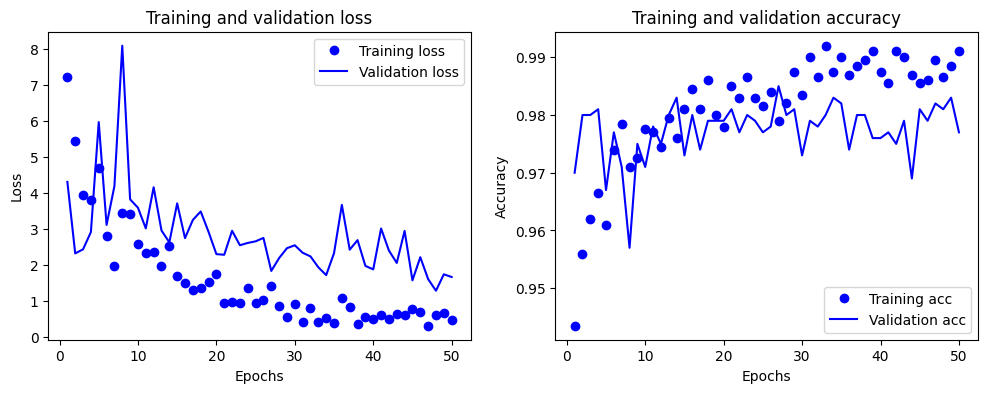

In [31]:
show_history(history)

In [33]:
test_model = keras.models.load_model(
    "/content/features_extraction_with_data_augmentation.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 96ms/step - loss: 2.1917 - accuracy: 0.9760
Test accuracy: 0.976


In [35]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Fine tuning**

**Freezing all layers until the fourth from the last**

In [36]:
conv_base.layers

In [46]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0     

In [39]:
model.layers

In [47]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [48]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.h5",
        save_best_only=True,
        monitor="val_loss")
]

In [49]:
# 共同训练解冻的这些层和新添加的部分
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.5792 - accuracy: 0.9885

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 14s 177ms/step - loss: 0.5792 - accuracy: 0.9885 - val_loss: 1.6992 - val_accuracy: 0.9800
Epoch 2/30
63/63 [==============================] - 10s 156ms/step - loss: 0.2839 - accuracy: 0.9915 - val_loss: 1.9475 - val_accuracy: 0.9770
Epoch 3/30
63/63 [==============================] - 13s 201ms/step - loss: 0.3550 - accuracy: 0.9880 - val_loss: 1.5819 - val_accuracy: 0.9790
Epoch 4/30
63/63 [==============================] - 11s 168ms/step - loss: 0.2805 - accuracy: 0.9925 - val_loss: 1.2863 - val_accuracy: 0.9770
Epoch 5/30
63/63 [==============================] - 12s 183ms/step - loss: 0.3578 - accuracy: 0.9895 - val_loss: 1.2501 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 11s 171ms/step - loss: 0.4127 - accuracy: 0.9900 - val_loss: 1.3738 - val_accuracy: 0.9770
Epoch 7/30
63/63 [==============================] - 12s 182ms/step - loss: 0.2514 - accuracy: 0.9940 - val_loss: 1.3495 - val_accuracy: 0.9770
Epoch 8/30

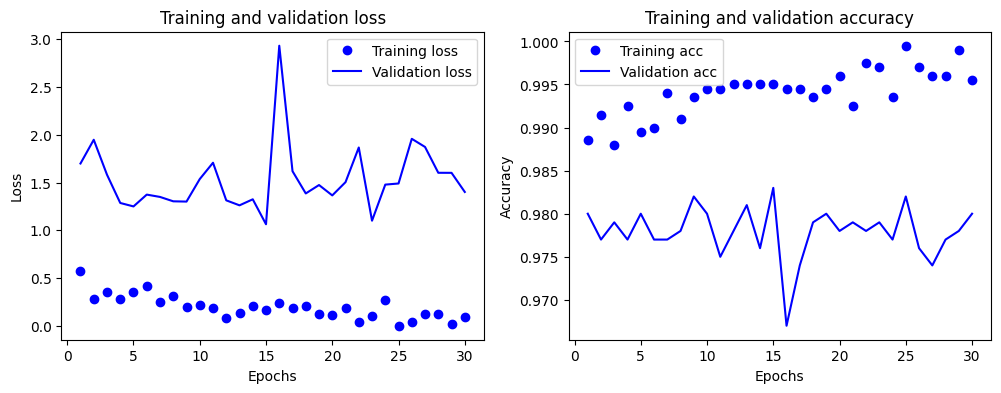

In [50]:
show_history(history)

In [51]:
model = keras.models.load_model("/content/fine_tuning.h5")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 95ms/step - loss: 1.8714 - accuracy: 0.9745
Test accuracy: 0.975
